In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

#loading the model and preprocesing image
model = models.resnet50(weights='IMAGENET1K_V1')
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = Image.open("test_data\dog_test.jpg")
input_tensor = preprocess(img).unsqueeze(0) # Shape becomes [1, 3, 224, 224]

with torch.no_grad():
    output = model(input_tensor)

target_class = output.argmax(dim=1).item()

print(f"Model predicts class index: {target_class}")

In [ ]:
import torch.nn.functional as F

def integrated_gradients(inputs, model, target_class, baseline=None, steps=50):

  if baseline==None:
    baseline=torch.zeros_like(inputs)

  alphas = torch.linspace(0,1,steps)
  delta = inputs - baseline
  grads_list = []

  for alpha in alphas:

    #interpolated image calculation
    interp_image = (baseline + alpha * delta).detach()
    interp_image.requires_grad_(True)

    model.zero_grad()
    #running the model on the given image
    output = model(interp_image)
    score = output[ :, target_class]

    score.backward()

    grads_list.append(interp_image.grad.clone().detach())

  avg_grads = torch.stack(grads_list).mean(dim=0)
  ig = delta * avg_grads

  return ig

In [46]:
attribution = integrated_gradients(input_tensor, model, target_class, None)

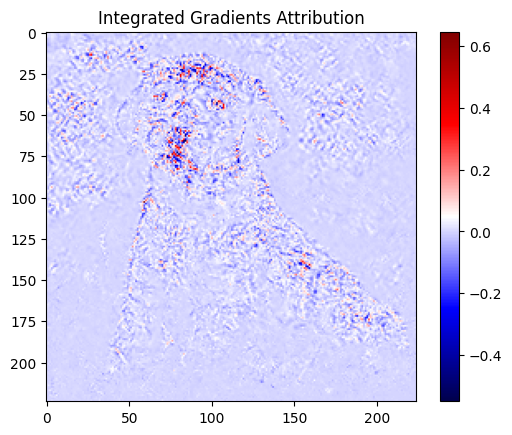

In [ ]:
import matplotlib.pyplot as plt
def visualize_attribution(attribution_tensor):

    # sum attribution tensor for visualizaiton
    heatmap = attribution_tensor.squeeze(0).abs().sum(dim=0).cpu().detach().numpy()

    plt.imshow(heatmap, cmap='inferno')
    plt.colorbar()
    plt.title("Integrated Gradients Attribution")
    plt.show()

visualize_attribution(attribution)

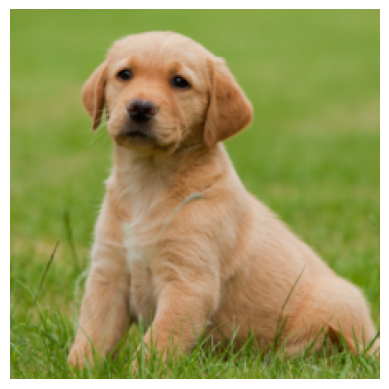

In [ ]:
##CODE WRITTEN BY AI

def show_tensor_image(tensor):
    # 1. Remove the batch dimension [1, 3, 224, 224] -> [3, 224, 224]
    img = tensor.squeeze(0)

    # 2. Swap dimensions: [3, 224, 224] -> [224, 224, 3]
    img = img.permute(1, 2, 0)

    # 3. Undo normalization (Approximate values for ImageNet)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img * std + mean

    # 4. Clip to make sure values are between 0 and 1
    img = torch.clamp(img, 0, 1)

    plt.imshow(img.detach().numpy())
    plt.axis('off')
    plt.show()

show_tensor_image(input_tensor)